# Topic Modeling Clustering

In this notebook we visualize a previously generated topic model.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np

## Configuration

In [2]:
db_dir = './db'
data_prefix = 'winereviews'

In [3]:
data_prefix

'winereviews'

## Import Topic Data

We import our previously generated model.

In [52]:
# topic_model_suffix = '_NMF'
topic_model_suffix = ''

In [53]:
LABELS = pd.read_csv(f"{db_dir}/{data_prefix}-LABELS.csv").set_index('doc_id')
VOCAB = pd.read_csv(f"{db_dir}/{data_prefix}-VOCAB.csv").set_index('term_str')
BOW = pd.read_csv(f"{db_dir}/{data_prefix}-BOW.csv").set_index(['doc_id','term_str'])
TOPICS = pd.read_csv(f"{db_dir}/{data_prefix}-TOPICS{topic_model_suffix}.csv").set_index('topic_id')
THETA = pd.read_csv(f"{db_dir}/{data_prefix}-THETA{topic_model_suffix}.csv").set_index('doc_id')
THETA.columns.name = 'topic_id'
THETA.columns = [int(col) for col in THETA.columns] # Should change columns to strings
PHI = pd.read_csv(f"{db_dir}/{data_prefix}-PHI{topic_model_suffix}.csv").set_index('topic_id')
PHI.columns.name = 'term_str'

In [54]:
n_topics = len(TOPICS)
topic_cols = [t for t in range(n_topics)]

# Inspect Results

## Sort Topics by Doc Weight

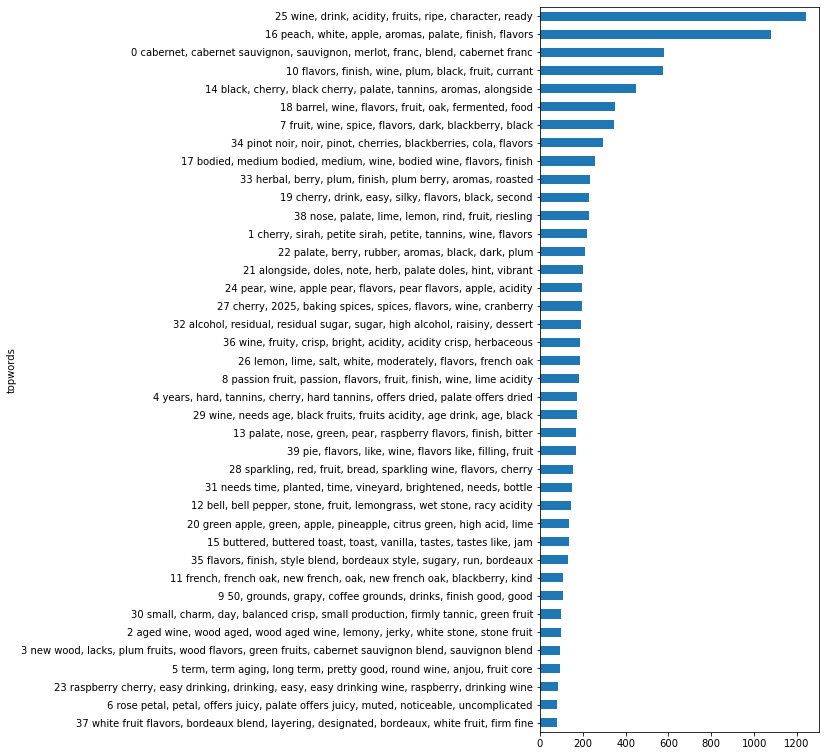

In [55]:
TOPICS.sort_values('doc_weight_sum', ascending=True)\
    .plot.barh(y='doc_weight_sum', x='topwords', figsize=(5, n_topics/3), legend=False);

## Clutser Topics

In [56]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [57]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, n_topics / 3))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [58]:
SIMS = pdist(normalize(PHI), metric='cosine')
TREE = sch.linkage(SIMS, method='ward')

<Figure size 432x288 with 0 Axes>

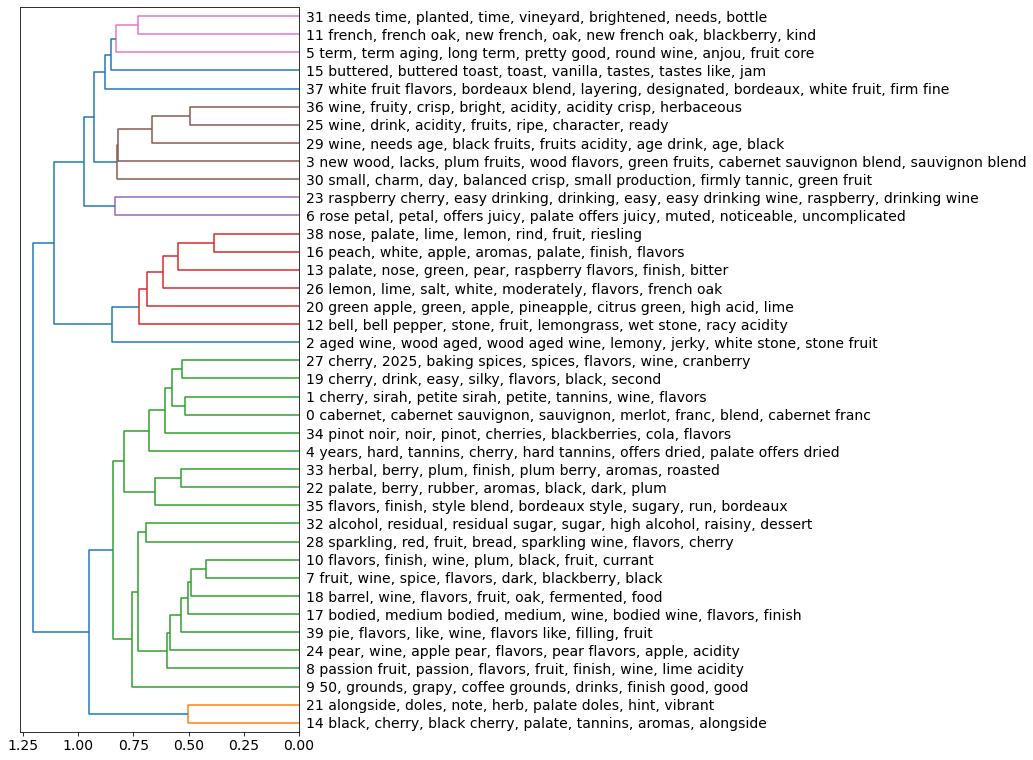

In [59]:
plot_tree(TREE, TOPICS.topwords.to_list())

## Group Topics by Label

In [60]:
LABELS.columns

Index(['doc_variety', 'doc_points', 'doc_title', 'doc_province', 'doc_price',
       'doc_label', 'doc_place', 'doc_taster'],
      dtype='object')

In [61]:
group_col = 'doc_label'

In [62]:
group_vals = LABELS[group_col].value_counts().to_frame('n')
group_vals.index.name = 'group_id'

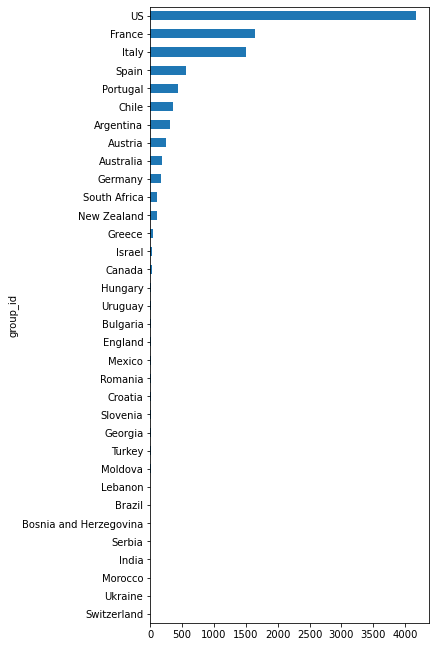

In [63]:
group_vals.sort_values('n').plot.barh(figsize=(5,len(group_vals) / 3), legend=False);

In [64]:
G = THETA.join(LABELS).groupby(group_col)[topic_cols].mean()
G.index.name = 'group_id'
G.columns = TOPICS.topwords

### Heatmap of Labels and Topics

In [65]:
G.style.background_gradient()

topwords,"0 cabernet, cabernet sauvignon, sauvignon, merlot, franc, blend, cabernet franc","1 cherry, sirah, petite sirah, petite, tannins, wine, flavors","2 aged wine, wood aged, wood aged wine, lemony, jerky, white stone, stone fruit","3 new wood, lacks, plum fruits, wood flavors, green fruits, cabernet sauvignon blend, sauvignon blend","4 years, hard, tannins, cherry, hard tannins, offers dried, palate offers dried","5 term, term aging, long term, pretty good, round wine, anjou, fruit core","6 rose petal, petal, offers juicy, palate offers juicy, muted, noticeable, uncomplicated","7 fruit, wine, spice, flavors, dark, blackberry, black","8 passion fruit, passion, flavors, fruit, finish, wine, lime acidity","9 50, grounds, grapy, coffee grounds, drinks, finish good, good","10 flavors, finish, wine, plum, black, fruit, currant","11 french, french oak, new french, oak, new french oak, blackberry, kind","12 bell, bell pepper, stone, fruit, lemongrass, wet stone, racy acidity","13 palate, nose, green, pear, raspberry flavors, finish, bitter","14 black, cherry, black cherry, palate, tannins, aromas, alongside","15 buttered, buttered toast, toast, vanilla, tastes, tastes like, jam","16 peach, white, apple, aromas, palate, finish, flavors","17 bodied, medium bodied, medium, wine, bodied wine, flavors, finish","18 barrel, wine, flavors, fruit, oak, fermented, food","19 cherry, drink, easy, silky, flavors, black, second","20 green apple, green, apple, pineapple, citrus green, high acid, lime","21 alongside, doles, note, herb, palate doles, hint, vibrant","22 palate, berry, rubber, aromas, black, dark, plum","23 raspberry cherry, easy drinking, drinking, easy, easy drinking wine, raspberry, drinking wine","24 pear, wine, apple pear, flavors, pear flavors, apple, acidity","25 wine, drink, acidity, fruits, ripe, character, ready","26 lemon, lime, salt, white, moderately, flavors, french oak","27 cherry, 2025, baking spices, spices, flavors, wine, cranberry","28 sparkling, red, fruit, bread, sparkling wine, flavors, cherry","29 wine, needs age, black fruits, fruits acidity, age drink, age, black","30 small, charm, day, balanced crisp, small production, firmly tannic, green fruit","31 needs time, planted, time, vineyard, brightened, needs, bottle","32 alcohol, residual, residual sugar, sugar, high alcohol, raisiny, dessert","33 herbal, berry, plum, finish, plum berry, aromas, roasted","34 pinot noir, noir, pinot, cherries, blackberries, cola, flavors","35 flavors, finish, style blend, bordeaux style, sugary, run, bordeaux","36 wine, fruity, crisp, bright, acidity, acidity crisp, herbaceous","37 white fruit flavors, bordeaux blend, layering, designated, bordeaux, white fruit, firm fine","38 nose, palate, lime, lemon, rind, fruit, riesling","39 pie, flavors, like, wine, flavors like, filling, fruit"
group_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.079263,0.007864,0.004949,0.010638,0.016726,0.007849,0.005549,0.027312,0.026039,0.008613,0.138850,0.013714,0.007580,0.037508,0.008033,0.018943,0.154307,0.023665,0.013943,0.012703,0.008836,0.007870,0.034117,0.006158,0.008985,0.013918,0.010576,0.020338,0.014650,0.007968,0.006879,0.009544,0.033308,0.096082,0.013717,0.028335,0.011935,0.007988,0.014181,0.020564
Australia,0.040272,0.019485,0.006848,0.008526,0.016412,0.007774,0.007142,0.035747,0.026216,0.030269,0.074042,0.021829,0.012356,0.018090,0.015734,0.009105,0.112192,0.041055,0.053180,0.051213,0.017964,0.017594,0.025731,0.005826,0.040114,0.042090,0.011665,0.055975,0.007189,0.017238,0.011407,0.014370,0.018532,0.025975,0.022288,0.017346,0.008661,0.004983,0.015993,0.011569
Austria,0.007559,0.009679,0.022950,0.007294,0.007065,0.010297,0.008394,0.020515,0.017915,0.004710,0.026524,0.007142,0.013157,0.058371,0.014792,0.007364,0.104655,0.037960,0.034182,0.024736,0.019399,0.006004,0.010396,0.011133,0.038313,0.223488,0.020879,0.012485,0.022597,0.028025,0.011391,0.009807,0.013602,0.013367,0.012780,0.009298,0.025742,0.005942,0.049595,0.010496
Bosnia 

### Top Topic per Label Group

In [66]:
group_vals['top_topic'] = G.T[group_vals.index].idxmax()

In [67]:
group_vals.sort_values('top_topic')

,n,top_topic
group_id,,
Switzerland,1,"0 cabernet, cabernet sauvignon, sauvignon, mer..."
Moldova,5,"0 cabernet, cabernet sauvignon, sauvignon, mer..."
Mexico,10,"0 cabernet, cabernet sauvignon, sauvignon, mer..."
Bulgaria,12,"0 cabernet, cabernet sauvignon, sauvignon, mer..."
Morocco,1,"1 cherry, sirah, petite sirah, petite, tannins..."
Lebanon,2,"1 cherry, sirah, petite sirah, petite, tannins..."
Israel,32,"10 flavors, finish, wine, plum, black, fruit, ..."
Italy,1504,"14 black, cherry, black cherry, palate, tannin..."
Ukraine,1,"16 peach, white, apple, aromas, palate, finish..."


### Top Label Group per Topic

In [68]:
G.idxmax().to_frame('label').sort_values('label')

,label
topwords,
"27 cherry, 2025, baking spices, spices, flavors, wine, cranberry",Australia
"21 alongside, doles, note, herb, palate doles, hint, vibrant",Bosnia and Herzegovina
"17 bodied, medium bodied, medium, wine, bodied wine, flavors, finish",Bosnia and Herzegovina
"14 black, cherry, black cherry, palate, tannins, aromas, alongside",Bosnia and Herzegovina
"36 wine, fruity, crisp, bright, acidity, acidity crisp, herbaceous",Brazil
"3 new wood, lacks, plum fruits, wood flavors, green fruits, cabernet sauvignon blend, sauvignon blend",Bulgaria
"18 barrel, wine, flavors, fruit, oak, fermented, food",Canada
"35 flavors, finish, style blend, bordeaux style, sugary, run, bordeaux",Chile
"33 herbal, berry, plum, finish, plum berry, aromas, roasted",Croatia
